# Initial Guess Estimator for Non-linear Models

This notebook systematically determines optimal initial parameter guesses for the non-linear models (Models 1 and 2) to ensure robust convergence of the optimization algorithms used in the main analysis.

**Purpose**: Generate and save initial guesses to `utils/initial_guesses.json` that will be used by the main analysis notebook.

**Approach**:
- **Model 1**: Grid search over non-linear parameters (β) with Variable Projection
- **Model 2**: Linearization technique to approximate initial parameters

In [23]:
from utils.data_loader import load_data
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import pandas as pd
import json

df, x_mean, x_std = load_data(normalize=True)
print(f"Data loaded: {len(df)} observations")
print(f"Normalization parameters: mean={x_mean:.4f}, std={x_std:.4f}")

Data initialized into df
Data has been normalized.
Data loaded: 50 observations
Normalization parameters: mean=25.5000, std=14.5774


## Visualize the Data

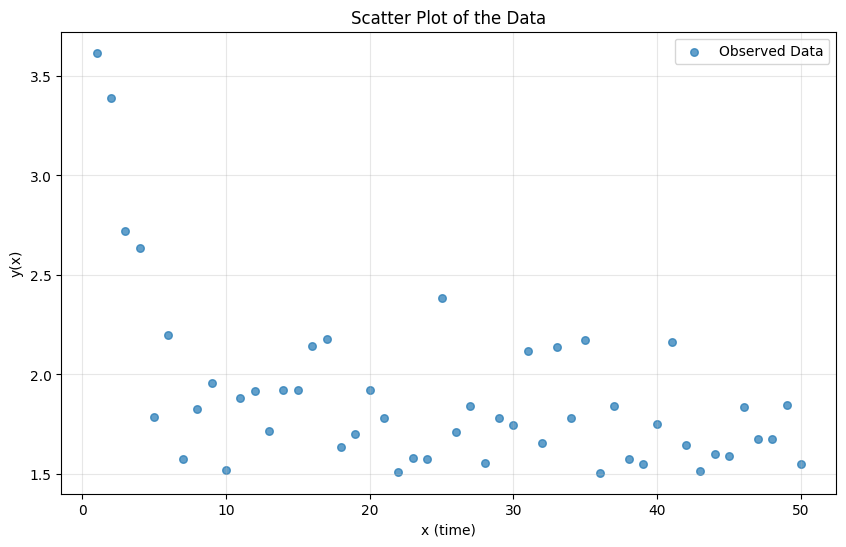

x range: [1.000, 50.000]
y range: [1.506, 3.617]
y appears to level off at approximately: 1.716


In [16]:
# Visualize the data to understand about parameter ranges
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], label='Observed Data', alpha=0.7, s=30)
plt.title("Scatter Plot of the Data")
plt.xlabel("x (time)")
plt.ylabel("y(x)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Data summary, for numerical values
print(f"x range: [{df['x'].min():.3f}, {df['x'].max():.3f}]")
print(f"y range: [{df['y'].min():.3f}, {df['y'].max():.3f}]")
print(f"y appears to level off at approximately: {df['y'].iloc[-5:].mean():.3f}")

## Methodology for Initial Parameter Estimation

### Strategy Overview

#### Model 1: Non-linear Exponential
$y(t)=\alpha_{0} + \alpha_{1}e^{\beta_{1}t} + \alpha_{2}e^{\beta_{2}t}$

**Grid Search Approach:**
- Since this model is linear in the α parameters but non-linear in the β parameters, we use Variable Projection.
- We perform a grid search over reasonable ranges for β₁ and β₂.
- For each (β₁, β₂) pair, we solve for the optimal α parameters using linear least squares.
- The (β₁, β₂) pair that yields the lowest RSS provides our initial guess.

**Key Considerations:**
- β values typically negative for decay processes (data appears to level off, settle at around 1.7 - 1.5).
- Ensure β₁ and β₂ are sufficiently different to avoid numerical issues.
- Use normalized (scaled) data for numerical stability.

#### Model 2: Non-linear Ratio
$y(t)=\frac{\alpha_{0} + \alpha_{1}t}{\beta_{0} + \beta_{1}t}$

**Linearization Approach:**
- Rearrange the model equation: $y(t) \approx c_0 + c_1 \cdot t + c_2 \cdot (y \cdot t)$
- This converts the problem to linear regression with predictors [1, t, y·t].
- From the fitted coefficients, derive initial guesses for the original parameters.
- The transformation assumes: $c_0 = \alpha_0/\beta_0$, $c_1 = \alpha_1/\beta_0$, $c_2 = -\beta_1/\beta_0$

**Key Considerations:**
- As t → ∞, y(t) → α₁/β₁ (from the data, this appears to be around 1.5).
- At t = 0, y(0) = α₀/β₀ (from the data, this starts near zero).
- Use these asymptotic properties to validate the initial guesses.

##### Initial Guess Estimation Implementation

In [26]:
# Using scaled data for finding guesses (better numerical stability)
x = df['x_scaled'].values
y = df['y'].values

# =============================================================================
# MODEL 1: Grid Search for Non-linear Parameters (betas)
# =============================================================================
print("=" * 70)
print("FINDING INITIAL GUESSES FOR MODEL 1")
print("=" * 70)

print("Model: y(t) = α₀ + α₁·exp(β₁·t) + α₂·exp(β₂·t)")
print("Strategy: Grid search over β parameters with Variable Projection")

print("-" * 70)

# Define a grid for beta1 and beta2
# Based on the plot, the curve rises and flattens, suggesting negative beta values
# (decay towards an asymptote)
beta_grid = np.linspace(-5.0, -0.1, 10)
min_rss = float('inf')
best_params = {}

print(f"Searching {len(beta_grid)}x{len(beta_grid)} = {len(beta_grid)**2} combinations...")
print(f"Beta range: [{beta_grid[0]:.2f}, {beta_grid[-1]:.2f}]")

# Iterate through all combinations of beta1 and beta2
for beta1_guess, beta2_guess in product(beta_grid, repeat=2):
    # Avoid beta1 and beta2 being too close (numerical issues)
    if abs(beta1_guess - beta2_guess) < 0.1:
        continue

    # For fixed betas, the model is linear in alphas: y = α₀ + α₁·exp(β₁·t) + α₂·exp(β₂·t)
    # Build design matrix: X = [1, exp(β₁·t), exp(β₂·t)]
    X = np.vstack([np.ones_like(x), np.exp(beta1_guess * x), np.exp(beta2_guess * x)]).T

    # Solve for [α₀, α₁, α₂] using linear least squares
    try:
        alphas, rss, _, _ = np.linalg.lstsq(X, y, rcond=None)

        # If this combination of betas gives a better fit, store the parameters
        if rss[0] < min_rss:
            min_rss = rss[0]
            best_params = {
                'alphas': alphas,
                'betas': [beta1_guess, beta2_guess]
            }
    except np.linalg.LinAlgError:
        # Skip this combination if linear system is singular
        continue

# Construct the final initial guesses for Model 1 in the format [α₀, α₁, β₁, α₂, β₂]
initial_guess_model1 = [
    best_params['alphas'][0],  # α₀
    best_params['alphas'][1],  # α₁
    best_params['betas'][0],   # β₁
    best_params['alphas'][2],  # α₂
    best_params['betas'][1]    # β₂
]

print("✓ Grid search complete!")
print("Best Initial Guesses for Model 1 (on scaled data):")
print(f"  α₀ (alpha0): {initial_guess_model1[0]:>10.4f}")
print(f"  α₁ (alpha1): {initial_guess_model1[1]:>10.4f}")
print(f"  β₁ (beta1):  {initial_guess_model1[2]:>10.4f}")
print(f"  α₂ (alpha2): {initial_guess_model1[3]:>10.4f}")
print(f"  β₂ (beta2):  {initial_guess_model1[4]:>10.4f}")
print(f"Resulting RSS from grid search: {min_rss:.6f}")

FINDING INITIAL GUESSES FOR MODEL 1

Model: y(t) = α₀ + α₁·exp(β₁·t) + α₂·exp(β₂·t)

Strategy: Grid search over β parameters with Variable Projection
----------------------------------------------------------------------
Searching 10x10 = 100 combinations...
Beta range: [-5.00, -0.10]

✓ Grid search complete!

Best Initial Guesses for Model 1 (on scaled data):
  α₀ (alpha0):     1.7809
  α₁ (alpha1):     0.0034
  β₁ (beta1):     -4.4556
  α₂ (alpha2):    -0.0057
  β₂ (beta2):     -3.9111

Resulting RSS from grid search: 2.538283


In [27]:
# =============================================================================
# MODEL 2: Linearization Method
# =============================================================================
print("" + "=" * 70)
print("FINDING INITIAL GUESSES FOR MODEL 2")
print("=" * 70)

print("Model: y(t) = (α₀ + α₁·t) / (β₀ + β₁·t)")
print("Strategy: Linearization technique")

print("-" * 70)

# The model can be linearized by rearranging:
# y(t) ≈ c₀ + c₁·t + c₂·(y·t)
# where: c₀ = α₀/β₀, c₁ = α₁/β₀, c₂ = -β₁/β₀
#
# This converts the non-linear problem into a linear regression with
# predictors: [1, t, y·t]

# Construct the design matrix for the linearized model
X_lin = np.vstack([np.ones_like(x), x, y * x]).T

try:
    # Solve for [c₀, c₁, c₂] using linear least squares
    coeffs, _, _, _ = np.linalg.lstsq(X_lin, y, rcond=None)
    c0, c1, c2 = coeffs

    # Derive initial guesses for original parameters
    # We set β₀ = 1 to resolve the scaling ambiguity
    # (since multiplying all parameters by a constant doesn't change the model)
    beta0_guess = 1.0
    alpha0_guess = c0 * beta0_guess  # α₀ = c₀ · β₀
    alpha1_guess = c1 * beta0_guess  # α₁ = c₁ · β₀
    beta1_guess = -c2 * beta0_guess  # β₁ = -c₂ · β₀

    initial_guess_model2 = [alpha0_guess, alpha1_guess, beta0_guess, beta1_guess]

    print("✓ Linearization complete!")
    print("Best Initial Guesses for Model 2 (on scaled data):")
    print(f"  α₀ (alpha0): {initial_guess_model2[0]:>10.4f}")
    print(f"  α₁ (alpha1): {initial_guess_model2[1]:>10.4f}")
    print(f"  β₀ (beta0):  {initial_guess_model2[2]:>10.4f}")
    print(f"  β₁ (beta1):  {initial_guess_model2[3]:>10.4f}")
    
    # Validate the asymptotic behavior
    asymptote = alpha1_guess / beta1_guess
    initial_value = alpha0_guess / beta0_guess
    print(f"Validation:")
    print(f"  As t → ∞, y(t) → α₁/β₁ = {asymptote:.4f}")
    print(f"  At t = 0, y(0) = α₀/β₀ = {initial_value:.4f}")

except np.linalg.LinAlgError:
    print("✗ Linearization method for Model 2 failed.")
    print("  Using fallback initial guesses.")
    initial_guess_model2 = [1.0, 1.0, 1.0, 1.0]  # Fallback guesses

print("" + "=" * 70)


FINDING INITIAL GUESSES FOR MODEL 2

Model: y(t) = (α₀ + α₁·t) / (β₀ + β₁·t)

Strategy: Linearization technique
----------------------------------------------------------------------
✓ Linearization complete!

Best Initial Guesses for Model 2 (on scaled data):
  α₀ (alpha0):     1.7882
  α₁ (alpha1):     0.8268
  β₀ (beta0):      1.0000
  β₁ (beta1):      0.5112

Validation:
  As t → ∞, y(t) → α₁/β₁ = 1.6175
  At t = 0, y(0) = α₀/β₀ = 1.7882



##### Save Initial Guesses to JSON File

The computed initial guesses will be saved to `utils/initial_guesses.json` for use in the main analysis notebook.

In [30]:
# Save initial guesses to a JSON file for later use in the main analysis notebook

# Prepare the data structure
initial_guesses = {
    "model1": initial_guess_model1,  # [α₀, α₁, β₁, α₂, β₂]
    "model2": initial_guess_model2   # [α₀, α₁, β₀, β₁]
}

# Save to JSON with pretty formatting
output_file = 'utils/initial_guesses.json'
with open(output_file, 'w') as f:
    json.dump(initial_guesses, f, indent=2)

print(f"✓ Initial guesses successfully saved to: {output_file}")


✓ Initial guesses successfully saved to: utils/initial_guesses.json


#### **Note**: 
These initial guesses are computed on **normalized (scaled) data**. Remember to transform β parameters back to the original scale when interpreting results: `β_original = β_scaled / x_std`